# When is the 3m SLE target reached for Aschwanden et al (2019)?

The script below estimates the year when Greeland surpasses a sea-level contribution of 4m using the large ensemble of Aschwanden et al (2019):

```@article{Aschwanden2019,
author = {Aschwanden, Andy and Fahnestock, Mark A. and Truffer, Martin and Brinkerhoff, Douglas J. and Hock, Regine and Khroulev, Constantine and Mottram, Ruth and Khan, S. Abbas},
doi = {10.1126/sciadv.aav9396},
journal = {Sci. Adv.},
number = {6},
pages = {eaav9396},
title = {{Contribution of the Greenland Ice Sheet to sea level over the next millennium}},
url = {http://advances.sciencemag.org/lookup/doi/10.1126/sciadv.aav9396},
volume = {5},
year = {2019}
}```

In [48]:
import pandas as pd
import pylab as plt
import numpy as np
import matplotlib.lines as mlines

In [49]:
# Load Aschwanden et al (2019) and convert mass to cm SLE (1 mm SLE = 362.5 Gt)

as19 = pd.read_csv("aschwanden_et_al_2019_les.gz")
as19["SLE (cm)"] = -as19["Mass (Gt)"] / 362.5 / 10
as19 = as19.astype({"RCP": int, "Experiment": int})

as19_ctrl = pd.read_csv("aschwanden_et_al_2019_ctrl.gz")
as19_ctrl["SLE (cm)"] = -as19_ctrl["Mass (Gt)"] / 362.5 / 10
as19_ctrl = as19_ctrl.astype({"RCP": int, "Resolution (m)": int})

# Let's pick the "control" simulation
as19_ctrl = as19_ctrl[(as19_ctrl["Experiment"] == "CTRL") & (as19_ctrl["Resolution (m)"] == 900)]


In [50]:
# Target 300 cm SLE
target = 300

In [45]:
rcps = [26, 45,85]
quantiles = [0.16, 0.50, 0.84]
lws = [0.75, 1.5, 2.25]
rcp_col_dict = {"CTRL": "k", "85": "#990002", "45": "#5492CD", "26": "#003466"}

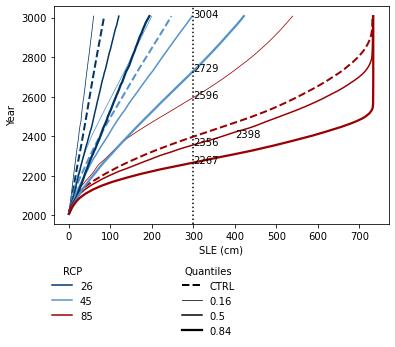

In [47]:

fig = plt.figure()
ax = fig.add_subplot(111)
for rcp in rcps:
    df = as19_ctrl
    m_df = df[df["RCP"] == rcp]
    # Filter by  395 cm < sle < 405 cm
    year_df = m_df[(m_df["SLE (cm)"] > target - 5) & (m_df["SLE (cm)"] < target + 5)]        
    year = year_df.mean()["Year"]
    ax.plot(m_df["SLE (cm)"], m_df["Year"], color=rcp_col_dict[str(rcp)], lw=2, ls="dashed")
if year is not np.nan:
    ax.annotate(f"{year:.0f}", (400, year), xycoords="data")
for q, lw in zip(quantiles, lws):
    df = as19.groupby(by=["Year", "RCP"]).quantile(q=q).reset_index()
    for rcp in rcps:
        m_df = df[df["RCP"] == rcp]
        # Filter by  395 cm < sle < 405 cm
        year_df = m_df[(m_df["SLE (cm)"] > target - 5) & (m_df["SLE (cm)"] < target + 5)]
        year = year_df.mean()["Year"]
        ax.plot(m_df["SLE (cm)"], m_df["Year"], color=rcp_col_dict[str(rcp)], lw=lw)
        if year is not np.nan:
            ax.annotate(f"{year:.0f}", (target, year), xycoords="data")

l_rcp = []
for rcp in rcps:
    l_rcp.append(mlines.Line2D(
        [],
        [],
        color=rcp_col_dict[str(rcp)],
        linewidth=1.5,
        linestyle="solid",
        label=rcp,
))
                 
legend_1 = ax.legend(
    handles=l_rcp, loc="upper left", bbox_to_anchor=(0.1, 0.01, 0, 0), bbox_transform=plt.gcf().transFigure, title="RCP"
)
legend_1.get_frame().set_linewidth(0.0)
legend_1.get_frame().set_alpha(0.0)

l_q = []
l_q.append(mlines.Line2D(
    [],
    [],
    color="k",
    linewidth=2,
    linestyle="dashed",
    label="CTRL",
))

for q, lw in zip(quantiles, lws):
    l_q.append(mlines.Line2D(
        [],
        [],
        color="k",
        linewidth=lw,
        linestyle="solid",
        label=q,
))
                 
legend_2 = ax.legend(
    handles=l_q, loc="upper left", bbox_to_anchor=(0.4, 0.01, 0, 0), bbox_transform=plt.gcf().transFigure, title="Quantiles"
)
legend_2.get_frame().set_linewidth(0.0)
legend_2.get_frame().set_alpha(0.0)

# Pylab automacially removes first legend when legend is called a second time.
# Add legend 1 back
ax.add_artist(legend_1)

ax.axvline(target, color="k", linestyle="dotted")
ax.set_xlabel("SLE (cm)")
ax.set_ylabel("Year")
fig.savefig("3m_sle_target.pdf", bbox_inches="tight")